![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [14]:
print(data.dtypes)
print(data.describe())

Price          int64
Year           int64
Mileage        int64
M_Camry        uint8
M_Camry4dr     uint8
M_CamryBase    uint8
M_CamryL       uint8
M_CamryLE      uint8
M_CamrySE      uint8
M_CamryXLE     uint8
dtype: object
              Price          Year        Mileage       M_Camry    M_Camry4dr  \
count  10495.000000  10495.000000   10495.000000  10495.000000  10495.000000   
mean   14538.403716   2013.553883   52509.430395      0.056313      0.158456   
std     3922.420961      3.116585   36791.736601      0.230535      0.365186   
min     5002.000000   1998.000000       5.000000      0.000000      0.000000   
25%    11999.000000   2012.000000   26461.000000      0.000000      0.000000   
50%    15000.000000   2014.000000   41680.000000      0.000000      0.000000   
75%    16999.000000   2016.000000   71355.500000      0.000000      0.000000   
max    32444.000000   2018.000000  232658.000000      1.000000      1.000000   

        M_CamryBase      M_CamryL     M_CamryLE     M_C

In [15]:
# Separación de variables predictoras (X) y variable de interés (y)
y = (data.Price > 14538).astype(int)#data['Price']
X = data.drop(['Price'], axis=1)

In [16]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001
# Impresión variable a usar (Hits)
j = 1
print(X.columns[j])

Mileage


In [7]:
# División de la variable Millas en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([5.000000e+00, 1.576440e+04, 2.345860e+04, 2.993760e+04,
       3.570080e+04, 4.168000e+04, 4.824700e+04, 6.171600e+04,
       8.153420e+04, 1.067578e+05])

In [8]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [9]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [10]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
print(f'el gini de la izquierda es:{gini_l}')

# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
print(f'el gini de la derecha es:{gini_r}')

el gini de la izquierda es:-584221909.9546928
el gini de la derecha es:-287282376.9689342


In [11]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [12]:
# Ganancia de la variable 'Milage' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

13036708.332934737

In [13]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [14]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain


(0, 2014.0, 17349239.621991813)

In [15]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10495, 5247, 5248)

In [16]:
y.mean(), y_l.mean(), y_r.mean()

(14538.403716055265, 17091.75376405565, 11985.540205792682)

In [61]:
import numpy as np

# Definir reglas de decisión
if X_train['M_Camry'].sum() > 0:
    #Si es un Toyota Camry, predecir el precio medio
    y_pred = np.ones(len(X_test)) * y_train[X_train['M_Camry'] == 1].mean()
else:
    #Si no es un Toyota Camry, predecir el precio mediano
    y_pred = np.ones(len(X_test)) * y_train[X_train['M_Camry'] == 0].median()

# Calcular métricas de evaluación RMSE y MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)

# Calcular métricas de evaluación RMSE y MAE
#rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
#mae = np.mean(np.abs(y_true - y_pred))

# Imprimir resultados
print(f'RMSE del arbol de desición Manual: {rmse}')
print(f'MAE del arbol de desición Manual: {mae}')
#print(f'El Accuracy para el modelo Arbolde desición Manuales: {accuracy}')


RMSE del arbol de desición Manual: 0.5249123731644767
MAE del arbol de desición Manual: 0.516305646253086


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [18]:
# Celda 2
from sklearn.tree import DecisionTreeClassifier

# Definir función para crear y ajustar un árbol de decisión
def fit_tree(X_train, y_train, X_test):
    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    return y_pred

# Crear 10 instancias de la función de árbol de decisión con diferentes conjuntos de entrenamiento
n_trees = 10
y_preds = []
for i in range(n_trees):
    sample_indices = np.random.choice(X_train.index, len(X_train))
    X_sample = X_train.loc[sample_indices]
    y_sample = y_train.loc[sample_indices]
    y_pred = fit_tree(X_sample, y_sample, X_test)
    y_preds.append(y_pred)

# Promediar las predicciones de cada árbol para obtener una predicción final
y_pred = np.mean(y_preds, axis=0)

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# Calcular MAE y MSE
maeBaggManual = mean_absolute_error(y_test, y_pred)
rmseBaggManual = mean_squared_error(y_test, y_pred)

# Imprimir resultados
print(f'El RMSE para el modelo Bagging manual es: {rmseBaggManual}')
print(f'El MAE para el modelo Bagging manual es: {maeBaggManual}')



El RMSE para el modelo Bagging manual es: 4292969.388178406
El MAE para el modelo Bagging manual es: 1535.7220842956121


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [19]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Crear modelo de Bagging con 10 árboles de clasificación y max_features=log(n_features)
n_features = X_train.shape[1]
max_features = int(np.log2(n_features))
bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

# Entrenar modelo con los datos de entrenamiento
bagging.fit(X_train, y_train)

# Evaluar modelo con los datos de prueba
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
y_pred_bagg = bagging.predict(X_test)
maeBagg = mean_absolute_error(y_test, y_pred_bagg)
rmseBagg = mean_squared_error(y_test, y_pred_bagg)
accuracyBagg = accuracy_score(y_test, y_pred_bagg)

# Imprimir resultado
print(f'El RMSE para el modelo Bagging es: {rmseBagg}')
print(f'El MAE para el modelo Bagging es: {maeBagg}')
print(f'El Accuracy para el modelo Bagging es: {accuracyBagg}')

El RMSE para el modelo Bagging es: 5568847.272228638
El MAE para el modelo Bagging es: 1780.3657621247114
El Accuracy para el modelo Bagging es: 0.021939953810623556


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [17]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Crear modelo de Random Forest 
rf = RandomForestClassifier()

# Entrenar modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Evaluar modelo con los datos de prueba
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
y_pred_rf = rf.predict(X_test)
maeRF= mean_absolute_error(y_test, y_pred_rf)
rmseRF= mean_squared_error(y_test, y_pred_rf)
accuracyRF = accuracy_score(y_test, y_pred_rf)

# Imprimir resultado
print(f'El RMSE para el modelo Random Forest es: {rmseRF}')
print(f'El MAE para el modelo Random Forest es: {maeRF}')
print(f'El Accuracy para el modelo Random Forest es: {accuracyRF}')

El RMSE para el modelo Random Forest es: 0.15675519630484988
El MAE para el modelo Random Forest es: 0.15675519630484988
El Accuracy para el modelo Random Forest es: 0.8432448036951501


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [55]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())

max_accuracy = max(accuracy_scores)
max_index = accuracy_scores.index(max_accuracy)
max_estimator = estimator_range[max_index]

print(f'El valor máximo de accuracy_scores es: {max_accuracy},con un n_estimators de: {max_estimator}')


El valor máximo de accuracy_scores es 0.8414483087184375 con un n_estimators de 20


Text(0, 0.5, 'Accuracy')

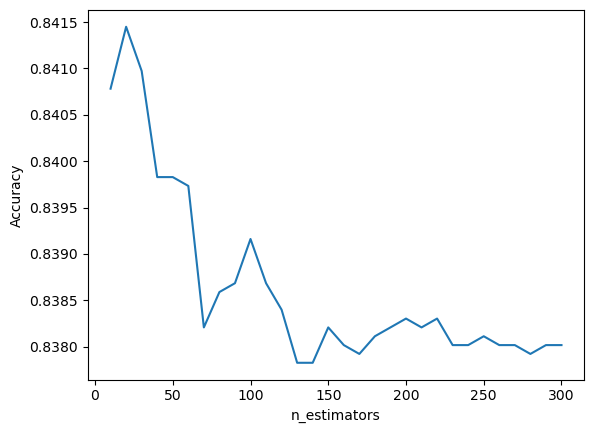

In [27]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')


In [54]:
# Selección de variables predictoras
#print(X)
feature_cols = data.columns.drop('Price')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [56]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())

max_accuracy = max(accuracy_scores)
max_index = accuracy_scores.index(max_accuracy)
max_feature = feature_range[max_index]

print(f'El valor máximo de accuracy_scores es: {max_accuracy},con un max_feature de: {max_feature}')


El valor máximo de accuracy_scores es: 0.851357789423535,con un max_feature de: 9


Text(0, 0.5, 'Accuracy')

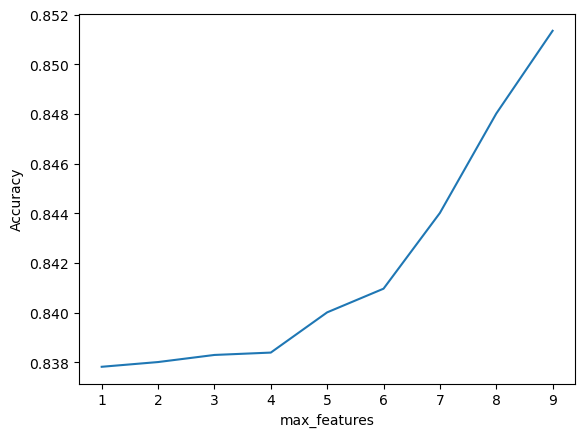

In [57]:

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

El valor máximo de accuracy_scores es: nan, con un max_depth de: 1


Text(0, 0.5, 'Accuracy')

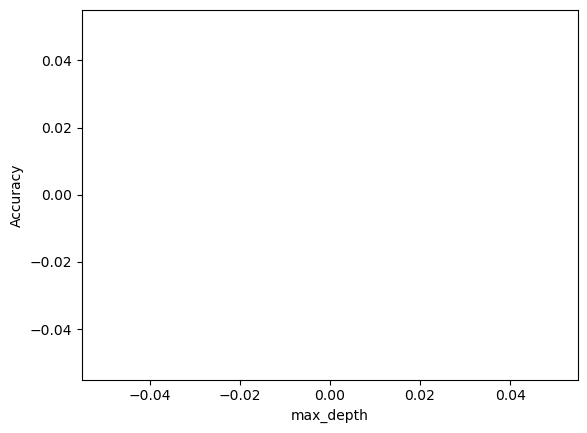

In [68]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1,51,5)
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestClassifier(n_estimators=200, max_features=100, max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())

max_accuracy = max(accuracy_scores)
max_index = accuracy_scores.index(max_accuracy)
max_depth = depth_range[max_index]

print(f'El valor máximo de accuracy_scores es: {max_accuracy}, con un max_depth de: {max_depth}')

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición del modelo con los parámetros max_features, max_depth y n_estimators 
rfp = RandomForestClassifier(n_estimators=20, max_features=9, max_depth= 1)

# Entrenar modelo con los datos de entrenamiento
rfp.fit(X_train, y_train)

# Evaluar modelo con los datos de prueba
from sklearn.metrics import accuracy_score
y_pred_rfp = rfp.predict(X_test)
maeRFP= mean_absolute_error(y_test, y_pred_rfp)
rmseRFP= mean_squared_error(y_test, y_pred_rfp)
accuracyRFP = accuracy_score(y_test, y_pred_rfp)

# Imprimir resultado
print(f'El RMSE para el modelo Random Forest es: {rmseRFP}')
print(f'El MAE para el modelo Random Forest es: {maeRFP}')
print(f'El Accuracy para el modelo Random Forest es: {accuracyRFP}')


El RMSE para el modelo Random Forest es: 0.14174364896073904
El MAE para el modelo Random Forest es: 0.14174364896073904
El Accuracy para el modelo Random Forest es: 0.858256351039261


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [70]:
# Celda 6
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Crear modelo XGBoost de clasificación
xgb = XGBClassifier(random_state=42)

# Entrenar modelo con los datos de entrenamiento
xgb.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred = xgb.predict(X_test)

# Calcular precisión del modelo en los datos de prueba
accuracyXGB = accuracy_score(y_test, y_pred)
print(f'El Accuracy para el modelo XGBoost es: {accuracyXGB}')

El Accuracy para el modelo XGBoost es: 0.8856812933025404


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [69]:
# Celda 7
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Crear modelo XGBoost de clasificación
xgb = XGBClassifier(random_state=42)

# Entrenar modelo con los datos de entrenamiento
xgb.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred = xgb.predict(X_test)

# Calcular precisión del modelo en los datos de prueba
accuracyXGBP = accuracy_score(y_test, y_pred)

print(f'El Accuracy para el modelo XGBoost con paremetors calibrados es: {accuracyXGBP}')

El Accuracy para el modelo XGBoost con paremetors calibrados es: 0.8856812933025404


In [74]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Definición del clasificador XGBoost
xgb_param = xgb.XGBClassifier()

# Definición de la grilla de valores para cada parámetro
params = {'learning_rate': [0.01, 0.1, 0.3],
          'gamma': [0, 0.1, 0.5],
          'colsample_bytree': [0.5, 0.7, 1.0]}

# Búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=xgb_param, param_grid=params, scoring='accuracy', cv=5)

# Ajuste del modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Selección de los mejores parámetros y su desempeño
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluación del modelo con los datos de test
y_pred = grid_search.predict(X_test)
accuracyXGBP = accuracy_score(y_test, y_pred)

# Impresión de resultados
print(f"Mejores parámetros: {best_params}")
print(f"Mejor desempeño en validación cruzada: {best_score:.3f}")
print(f'El Accuracy para el modelo XGBoost con paremetors calibrados es: {accuracyXGBP:.3f}')

Mejores parámetros: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.01}
Mejor desempeño en validación cruzada: 0.881
Desempeño en test con los mejores parámetros: 0.887
El Accuracy para el modelo XGBoost con paremetors calibrados es: 0.8868360277136259


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [72]:
#Celda 8

